# Experimental Part

## Import data

Initially, we observe the data. We can see that our dataset contains 220  images of UAV traffic images as well as 220 `.txt` files. In these `.txt` files, each row corresponds to the label of an object found on the corresponding image as well as 4 number that define the bounding box parameters of this particular object. These four number are the coordinates of the bottom left corner, the hight and the width of the box.

We imoprt the data, both images and labels. We also set a custom seed for experiment reprocucibility.

In [1]:
# Set seed for experiment reprocucibility
seed = 42

import os

data_dir = '../data/Exercise5/od_traffic_images_uav/'

frames = {}
labels = {}

for file in os.listdir(data_dir):
    if file.endswith(".png"):
        frames[int(file[-7:-4])] = file
    if file.endswith(".txt"):
        labels[int(file[-7:-4])] = file

print(f'Frames length = {len(frames)}')
print(f'Labels length = {len(labels)}')

Frames length = 220
Labels length = 220


## Train-Val-Test split

After that, we split our data into train, validation and test set.

In [2]:
from sklearn.model_selection import train_test_split

# Split into train - test

X_train, X_test, y_train, y_test = train_test_split(
                frames, labels, test_size=0.2, random_state=seed)


# Split into train - val

X_train, X_val, y_train, y_val = train_test_split(
                frames, labels, test_size=0.125, random_state=seed)


print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 192
Validation set size: 28
Test set size: 44


## Transform labels to COCO-format 

We create a function that parses the `.txt` files into labels and bounded boxes

In [3]:
def parse_dataset(line):
    tokens = line.split(' ')
    label = tokens[0]
    bbox = [float(item) for item in tokens[1:]]
    return label, bbox

Convert from custom structure to `FiftyOne` dataset object

In [6]:
import glob
import fiftyone as fo

# Custom label format to FO

annotations = {}

for k, v in frames.items():
    image_file = f'{data_dir}{v}'
    text_file = f'{data_dir}{v[:-3]}txt'
    annotations[image_file] = []
    with open(text_file, 'r') as file:
        for line in file:
            line = line.replace('\n', '')
            label, bbox = parse_dataset(line)
            annotations[image_file].append({
                "bbox": bbox,
                "label": label,
            })

In [ ]:
# Create dataset
dataset = fo.Dataset(name="custom-object-detection-dataset")

# Persist the dataset on disk in order to 
# be able to load it in one line in the future
dataset.persistent = True

# Add your samples to the dataset
for k, v in frames.items():
    filepath = f'{data_dir}{v}'
    sample = fo.Sample(filepath=filepath)

    # Convert detections to FiftyOne format
    detections = []
    for obj in annotations[filepath]:
        label = obj["label"]

        # Bounding box coordinates should be relative values
        # in [0, 1] in the following format:
        # [top-left-x, top-left-y, width, height]
        bounding_box = obj["bbox"]

        detections.append(
            fo.Detection(label=label, bounding_box=bounding_box)
        )

    # Store detections in a field name of your choice
    sample["ground_truth"] = fo.Detections(detections=detections)

    dataset.add_sample(sample)

Export to COCO format

In [38]:
export_dir = f"../data/coco-detection-dataset"
label_field = "ground_truth"  # for example

# Export the dataset
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.COCODetectionDataset,
    label_field=label_field,
)

 100% |█████████████████| 220/220 [829.9ms elapsed, 0s remaining, 265.1 samples/s]      


## Set-up MMDetection

In [8]:
# Verification

import mmdet
print(mmdet.__version__)

3.1.0


## Deformable DETR

### DETR

#### Overview

DETR (DEtection TRansformer) is an object detection algorithm (the goal of object detection is to predict a set of bounding boxes and category labels for each object of interest) proposed by Carion et al. to eliminate the need of hand-crafted components in modern object detectors. It leverages both convolutional neural networks (CNN) and Transformers represetnational capability to replace the hand crafted features.

#### Architecture

In this point, we are going to describe the modules comprising the DETR architecture. Like any other object detector, DETR is also utilizing a CNN as backbone. This CNN is typically a ResNet pre-trained on a very large set of images and serves as feature extractor for the object detector. The second module of DETR is an encoder-decoder transformer. This module expects a sequence as input (flattened activation map of the backbone CNN together with a positional encoding) and produces an encoding of the input sequence. Then, a transformer decoder is fed with a small fixed number of learned positional embeddings, called object queries, and attends to the encoder output producing an output embedding for each object query. Finally, these embeddings are passed to a FFN which predicts either a detection (class and bounding box) or the absence of the object on the specific image.

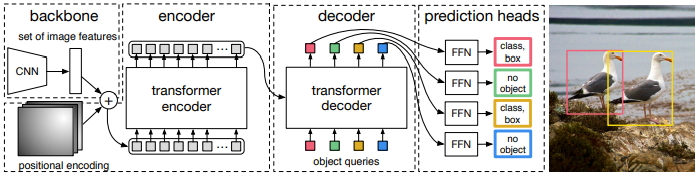

*Illustration of the DETR object detector*

### Limitations of DETR

DETR has 2 main limitations:
* Its training takes a lot of time compared to other object detection algorithms. This is mainly due to the utilization of Transformer module which takes a lot of epochs to converge.
* DETR delivers relatively low performance at detecting small objects. Modern object detectors usually exploit multi-scale features, where small objects are detected from high-resolution feature maps, which lead to unacceptable complexities for DETR.

### Deformable DETR

The Deformable DETR is a variation of the DETR architecture that addresses the aforementioned limitations of DETR. This is achieved by leveraging the deformable convolution, a powerful and efficient mechanism to attend to sparse spatial location. Inspired by deformable convolution, the deformable attention module only attends to a small set of key sampling points around a reference point, regardless of the spatial size of the feature maps. By assigning only a
small fixed number of keys for each query, the issues of convergence can be mitigated. To address the second limitation of DETR, the Deformable DETR utilizes multi-scale deformable attention modules to process CNN derived feature maps in order to detect objects of various scales, even smaller ones.

### Architecture

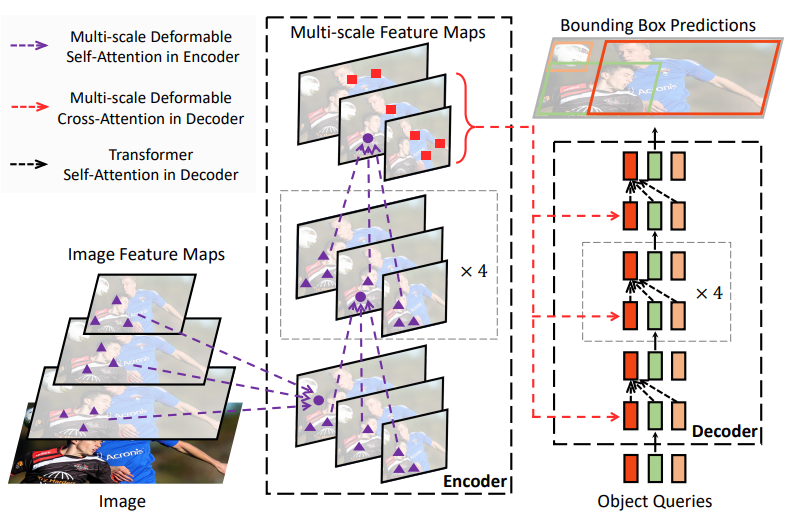

*Illustration of the Deformable DETR object detector*

## Model Zoo config 

The Deformable DETR config file contains the modules and parameters that comprise the Deformable DETR architecture. The configuration file we used is the `deformable-detr_r50_16xb2-50e_coco.py`. More specifically, the modules of the Deformable DETR, as well as the default values of their parameters are the following:

* `data_preprocessor`: This module is responsible to preprocess the input images by applying the necessary normalization and padding to them.
* `backbone`: As every object detector, Deformable DETR is utilizing a CNN as backbone model. According to the default values, this CNN is a ResNet trained on large image datasets and serves as the image feature extractor.
* `neck`: The neck module is an intermediate processing step between the backbone and the encoder of the transformer. The output feature maps of the ResNet are processed into  multi-scale feature maps and fed as input into the encoder having same number of channels but different scales.  

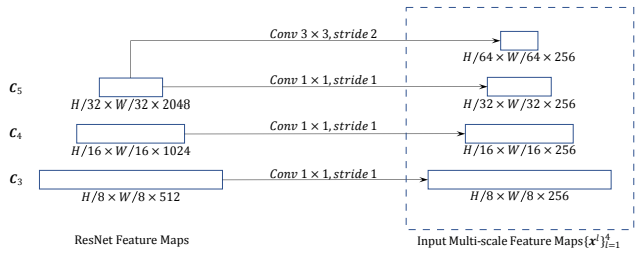

*Illustration of the neck module*

* `encoder`: The encoder extracts multi-scale feature maps from the output feature maps of ResNet. The module allows for information exchange among the feature maps and uses scale-level embeddings to identify the feature level of each query pixel. These embeddings are trained jointly with the network.
* `decoder`: The Deformable Transformer Decoder is a modification to the original decoder architecture of the DETR (Detection Transformer) model. It introduces deformable attention modules, which are used in place of the regular attention modules in the cross-attention modules of the decoder.
* `positional_encoding`: The positional encoding is very common in transformer models and is also included in DETR. Positional encoding describes the location or position of an entity in a sequence so that each position is assigned a unique representation.
* `bbox_head`: This parameter of the configuration defines the fully-connected network part of the model for the object classification and bounding box regression. This module's parameters are related to the classes of objects and corresponding losses of the region of interest.
* `train_cfg`: This parameter defines the loss function which we try to minimize and the algorithm to solve the assignement problem. According to the default values, the loss function is comprised of a focal loss component for the classification loss as well as a bounding box loss and a IoU loss component for the poition and scale .

## Train models

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Fri_Dec_17_18:16:03_PST_2021
Cuda compilation tools, release 11.6, V11.6.55
Build cuda_11.6.r11.6/compiler.30794723_0


In [7]:
import torch

ModuleNotFoundError: No module named 'torch'

### Default parameter values

### Selected parameter values

# Theoretical questions

1. 

2.

3.

4.

5.

# Object Tracking (Optional)

Filter a single video (20 frames) from the initial dataset

In [11]:
import gc

frames_keys = list(frames.keys())
selected_keys = [i for i in frames_keys if i < 20] 

selected_frames = {i: frames[i] for i in selected_keys}

del frames_keys, selected_keys
gc.collect()

from collections import OrderedDict

selected_frames_ordered = OrderedDict(sorted(selected_frames.items()))

del selected_frames
gc.collect()

selected_frames_ordered

OrderedDict([(0, 'im_00000.png'),
             (1, 'im_00001.png'),
             (2, 'im_00002.png'),
             (3, 'im_00003.png'),
             (4, 'im_00004.png'),
             (5, 'im_00005.png'),
             (6, 'im_00006.png'),
             (7, 'im_00007.png'),
             (8, 'im_00008.png'),
             (9, 'im_00009.png'),
             (10, 'im_00010.png'),
             (11, 'im_00011.png'),
             (12, 'im_00012.png'),
             (13, 'im_00013.png'),
             (14, 'im_00014.png'),
             (15, 'im_00015.png'),
             (16, 'im_00016.png'),
             (17, 'im_00017.png'),
             (18, 'im_00018.png'),
             (19, 'im_00019.png')])

The selected model is the [MixFormer: End-to-End Tracking with Iterative Mixed Attention](https://github.com/MCG-NJU/MixFormer) and the corresponding configuration file from MMDetection Model Zoo is `mixformer_cvt_500e_got10k.py`.